In [3]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
                            median_absolute_error, mean_absolute_percentage_error
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")


# definzioni funzioni varie
def timeserieFeatureExtractor(timeseries):
    timeseries['dayofweek'] = timeseries.index.dayofweek
    timeseries['quarter'] = timeseries.index.quarter
    timeseries['dayofyear'] = timeseries.index.dayofyear
    timeseries['dayofmonth'] = timeseries.index.day
    timeseries['weekofyear'] = timeseries.index.weekofyear
    timeseries['daysinmonth'] = timeseries.index.daysinmonth
    timeseries['month'] = timeseries.index.month
    timeseries['year'] = timeseries.index.year
    timeseries['weekend'] = np.where(timeseries.index.dayofweek > 4, 1, 0)
    timeseries.fillna(0,inplace=True)
    return 

def calcError(y_test, y_pred):
#     R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'R2: {round(R2,4)}')
    print(f'Mean Squared Error: {round(MSE,4)}')
    print(f'Root Mean Sqarred Error: {round(RMSE,4)}')
    print(f'Mean Absolute Error: {round(MAE,4)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE*100,4)}')
    return

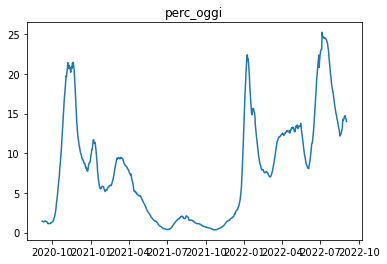

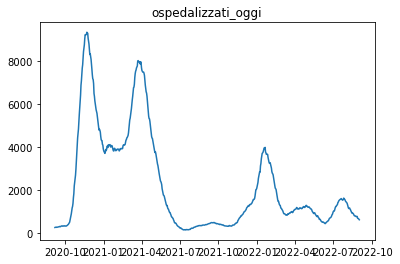

,perc_oggi,ospedalizzati_oggi
date,,
2022-08-23,14.254286,800.0
2022-08-24,14.137143,775.0
2022-08-25,14.265714,780.0
2022-08-26,14.380000,780.0
2022-08-27,14.650000,780.0
2022-08-28,14.705714,694.0
2022-08-29,14.742857,688.0
2022-08-30,14.430000,680.0
2022-08-31,14.257143,655.0


In [4]:
# creazione dataframe
data = pd.read_csv('https://www.lombacovid.it/story.csv',usecols = ['data','perc_story','ospedalizzati_story'])
data['data'] = pd.to_datetime(data['data'], dayfirst=True)
data.rename(columns = {'ospedalizzati_story':'ospedalizzati_oggi',
                       'perc_story':'perc_oggi',
                       'data':'date'},
                            inplace = True)
data.set_index('date',inplace=True)

# feature engineering on perc_oggi smoothed by running average of 7 days
running_average = 7     
data['perc_oggi'] = data['perc_oggi'].rolling(window=running_average).mean()
data = data.dropna()

for i in data:
    plt.plot(data[i])
    plt.title(i)
    plt.show()

# time series of ospedalizzati
series = data.ospedalizzati_oggi

# ts of perc_oggi -> sarimax exog series
exog_series = data.perc_oggi.shift(7).fillna(method='bfill')

# ts for sarimax prediction
exog_series_prediction = data.perc_oggi[data.index >= data.index[-7]]

display(data.tail(10))

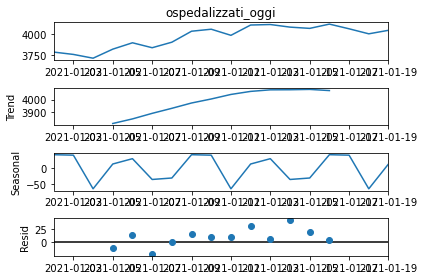

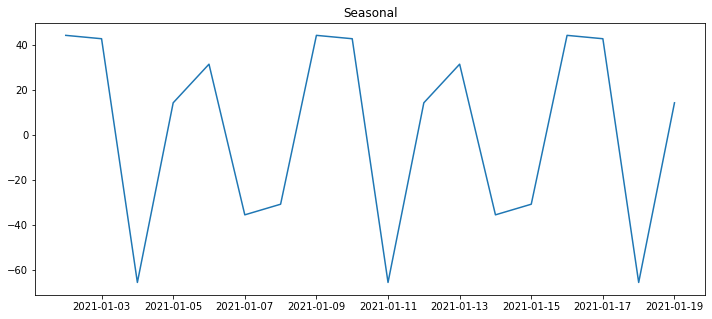

In [5]:
# visualize seasonal and trend component of ospedalizzati

sub_series = series[(series.index > '2021-01-01') & (series.index < '2021-01-20')]
result = seasonal_decompose(sub_series, model='additive')
result.plot()
plt.show()


plt.figure(figsize=(12,5))
plt.plot(result.seasonal)
plt.title('Seasonal')
plt.show()


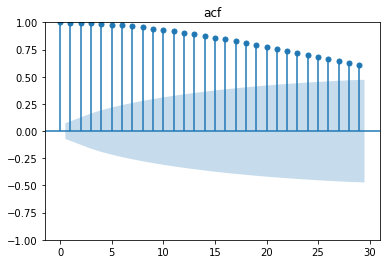

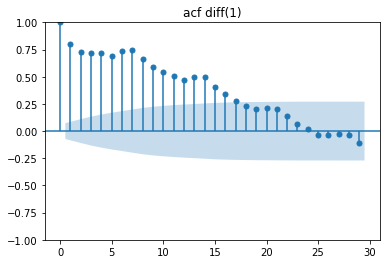

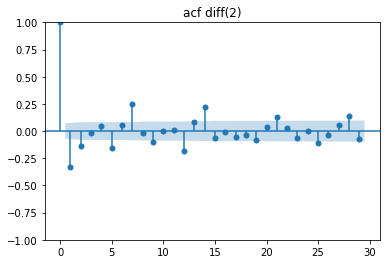

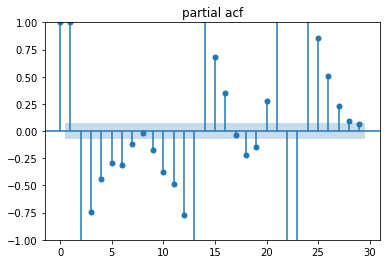

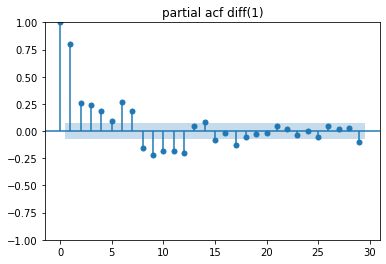

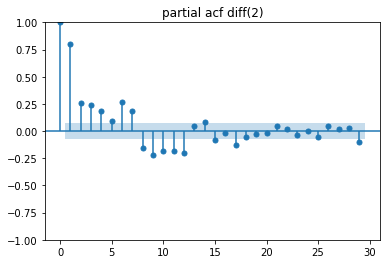

In [6]:
# visualize acf and partial acf of ospedalizzati 

plot_acf(series)
plt.title('acf')
plt.show()

plot_acf(series.diff().dropna())
plt.title('acf diff(1)')
plt.show()

plot_acf(series.diff().diff().dropna())
plt.title('acf diff(2)')
plt.show()

plot_pacf(series)
plt.title('partial acf')
plt.show()

plot_pacf(series.diff().dropna())
plt.title('partial acf diff(1)')
plt.show()

plot_pacf(series.diff().dropna())
plt.title('partial acf diff(2)')
plt.show()

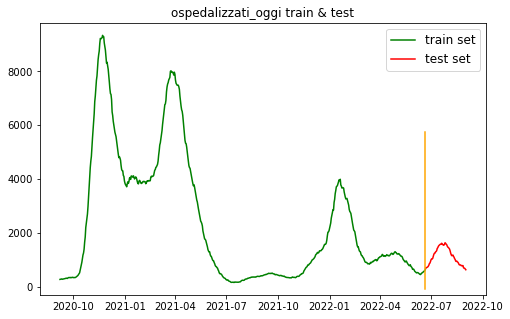

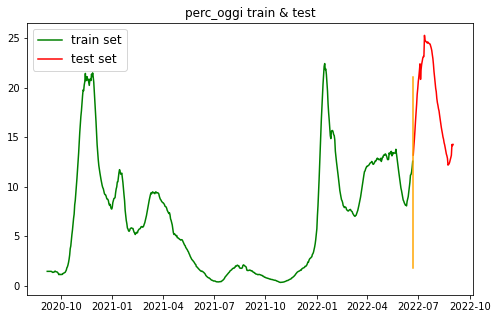

In [7]:
# splitting test and train
len_train_train_test = int(len(series.index)-len(series.index)*10/100)
index_train_test = list(data.index)[len_train_train_test]

y_train = series[series.index <= index_train_test]
y_test = series[series.index > index_train_test]

X_train = exog_series[exog_series.index <= index_train_test]
X_test = exog_series[exog_series.index > index_train_test]

# plot train
plt.figure(figsize=(8,5))
plt.plot(y_train,color='green',label='train set')
plt.plot(y_test,color='red',label='test set')
plt.axvline(x=index_train_test, ymin = 0.02, ymax = 0.6, color='orange')
plt.title('ospedalizzati_oggi train & test')
plt.legend(prop={'size': 12})
plt.show()


# plot train
plt.figure(figsize=(8,5))
plt.plot(X_train,color='green',label='train set')
plt.plot(X_test,color='red',label='test set')
plt.axvline(x=index_train_test, ymin = 0.1, ymax = 0.8, color='orange')
plt.title('perc_oggi train & test')
plt.legend(prop={'size': 12})
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=7497.131, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12034.501, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=12476.935, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=7202.996, Time=0.91 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=7206.525, Time=1.33 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=7205.193, Time=1.21 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=7323.948, Time=0.91 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=7204.902, Time=1.47 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=6956.329, Time=0.90 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=7058.191, Time=0.33 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=6936.314, Time=1.75 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=6924

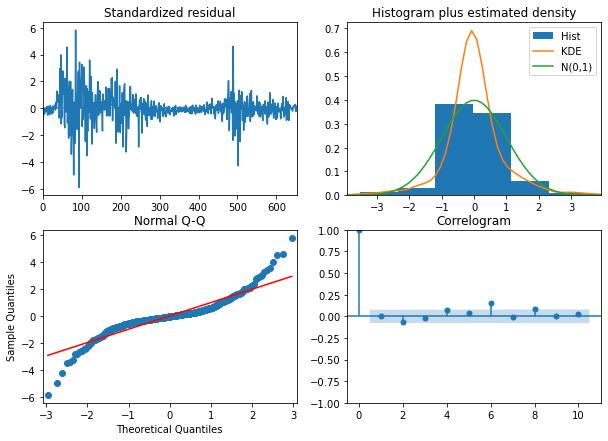

In [8]:
# -> SARIMA - train/test
model = pm.auto_arima(y = y_train,
                          start_p=1, start_q=1, d=None,
                          max_p=5, max_q=5,
                          start_P=0, start_Q=0, D=None,
                          seasonal=True,
                          m = 7,
                          test='adf',
                          n_jobs=-1,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)


# diagnostic of the model
model.plot_diagnostics(figsize=(10,7))
plt.show()

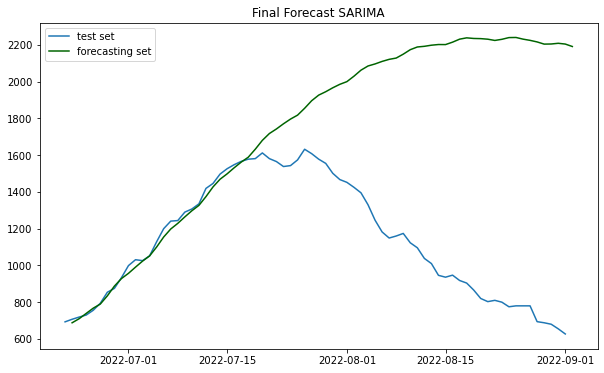

Error on test SARIMA
Mean Squared Error: 712474.3324
Root Mean Sqarred Error: 844.0819
Mean Absolute Error: 601.4592
Mean Absolute Percentage Error: 66.29


In [9]:
# Forecast of test set SARIMA
n_periods = len(y_test)
fc, confint = model.predict(n_periods = n_periods, return_conf_int=True)
index_of_fc = pd.date_range(y_test.index[1], periods = n_periods, freq='D')

# make series for plotting purpose
fc_series_test = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(10,6))
plt.plot(y_test,label='test set')
plt.plot(fc_series_test, color='darkgreen',label='forecasting set')
plt.legend()
plt.title("Final Forecast SARIMA")
plt.show()

# error
print('Error on test SARIMA')
calcError(y_test,fc_series_test)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=7051.846, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=7584.144, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=7072.376, Time=0.76 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7255.480, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=7582.598, Time=0.15 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=6951.869, Time=1.09 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=6937.103, Time=1.49 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=6946.469, Time=1.28 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=7151.670, Time=1.14 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=7057.780, Time=1.12 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=6934.299, Time=1.57 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=6965.294, Time=1.18 sec
 ARIMA(2,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=6

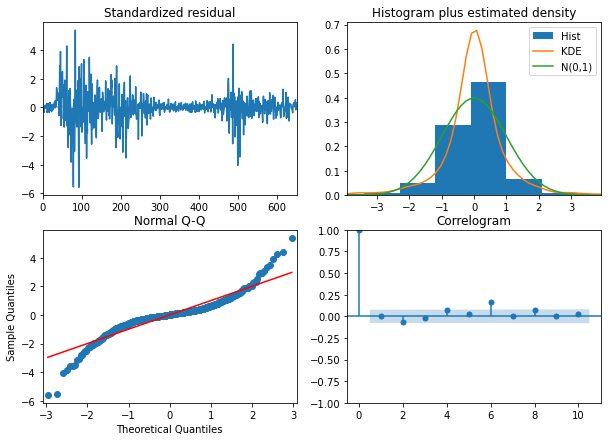

In [10]:
# -> SARIMAX Model train/test
sxmodel = pm.auto_arima(y_train.values.reshape(-1, 1), 
                        exogenous = X_train.values.reshape(-1, 1),
                        start_p=1, start_q=1, d=None,
                        max_p=5, max_q=5,
                        start_P=0, start_Q=0, D=None,
                        seasonal=True,
                        m = 7,
                        test='adf',
                        n_jobs=-1,
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

# diagnostic of the model
sxmodel.plot_diagnostics(figsize=(10,7))
plt.show()

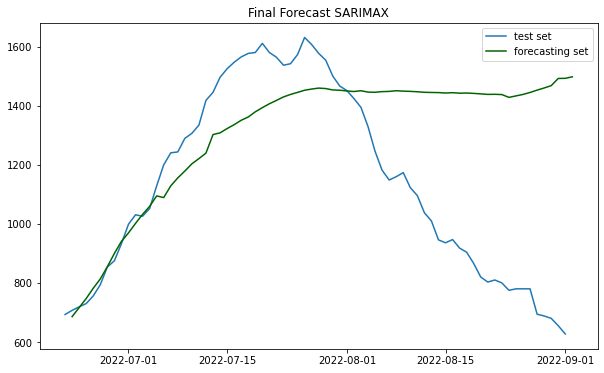

Error on test SARIMAX
Mean Squared Error: 136032.0178
Root Mean Sqarred Error: 368.8252
Mean Absolute Error: 267.1352
Mean Absolute Percentage Error: 29.9133


In [11]:
# Forecast of test set SARIMAX
n_periods = len(y_test)
fitted_values, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous = X_test.values.reshape(-1,1), 
                                  return_conf_int=True)
index_of_fc = pd.date_range(y_test.index[1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series_test = pd.Series(fitted_values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(10,6))
plt.plot(y_test,label='test set')
plt.plot(fitted_series_test, color='darkgreen',label='forecasting set')
plt.legend()
plt.title("Final Forecast SARIMAX")
plt.show()

# error
print('Error on test SARIMAX')
calcError(y_test,fitted_series_test)

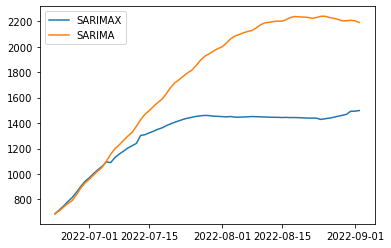

Difference between SARIMAX and SARIMA forecasting with train/test splitting:
Mean Squared Error: 278465.1135
Root Mean Sqarred Error: 527.6979
Mean Absolute Error: 430.6911
Mean Absolute Percentage Error: 30.0571


In [12]:
# difference between SARIMAX and SARIMA forecasting

plt.plot(fitted_series_test,label='SARIMAX')
plt.plot(fc_series_test,label='SARIMA')
plt.legend()
plt.show()


print('Difference between SARIMAX and SARIMA forecasting with train/test splitting:')
calcError(fitted_series_test,fc_series_test)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=8261.407, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13305.621, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13786.143, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=7938.892, Time=0.96 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=7940.488, Time=1.91 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=7940.621, Time=1.36 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=8073.595, Time=0.79 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=7938.649, Time=1.83 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=7902.120, Time=2.05 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=7919.892, Time=2.32 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=inf, Time=4.28 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=8043.384, Time=2.76 sec
 ARIMA(2,0,1)(2,0,2)[7] intercept   : AIC=7630

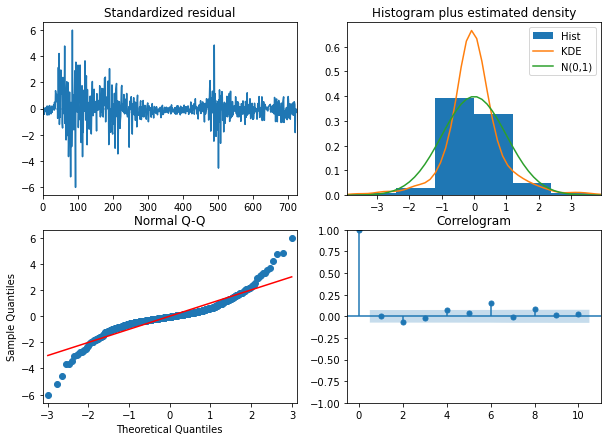

In [13]:
# -> SARIMA on all series
arima_model_all = pm.auto_arima(y = series,
                          start_p=1, start_q=1, d=None,
                          max_p=5, max_q=5,
                          start_P=0, start_Q=0, D=None,
                          seasonal=True,
                          m = 7,
                          test='adf',
                          n_jobs=-1,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

# diagnostic of the model
arima_model_all.plot_diagnostics(figsize=(10,7))
plt.show()



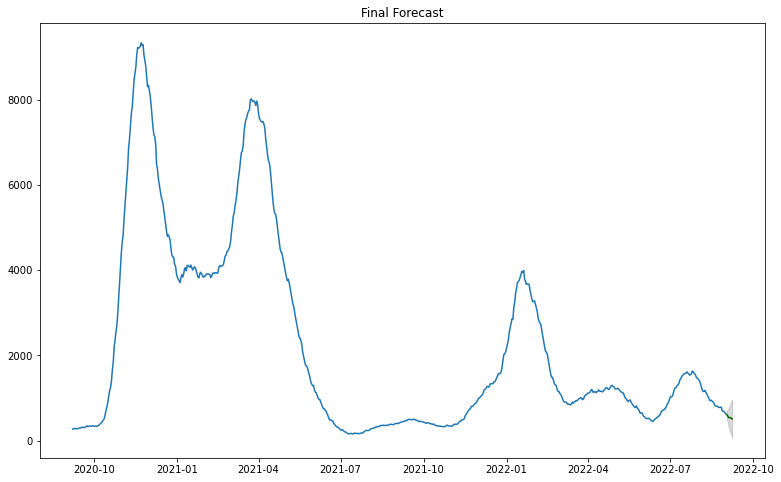

In [14]:
# Forecast SARIMA on all
n_periods = 7
fc, confint = arima_model_all.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(series.index[-1]+timedelta(days=1), periods = n_periods, freq='D')

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(13,8))
plt.plot(series)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=8184.859, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13176.510, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=11468.871, Time=1.19 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13253.154, Time=0.23 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=7921.234, Time=1.14 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=7945.451, Time=1.91 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=8241.361, Time=1.32 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=8040.255, Time=1.04 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=8249.904, Time=1.93 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=10134.955, Time=1.10 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=7699.200, Time=1.46 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=7780.495, Time=0.65 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=8196.179, Time=1.97 sec
 ARIMA(2,0,1)(1,0,1)[7] intercept 

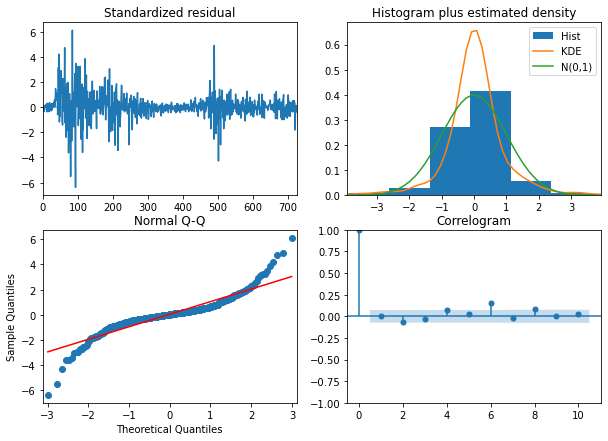

In [15]:
# -> SARIMAX Model on all ts
sxmodel_all = pm.auto_arima(series.values.reshape(-1, 1), 
                        exogenous=exog_series.values.reshape(-1, 1),
                        start_p=1, start_q=1, d=None,
                        max_p=5, max_q=5,
                        start_P=0, start_Q=0, D=None,
                        seasonal=True,
                        m = 7,
                        test='adf',
                        n_jobs=-1,
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

# diagnostic of the model
sxmodel_all.plot_diagnostics(figsize=(10,7))
plt.show()

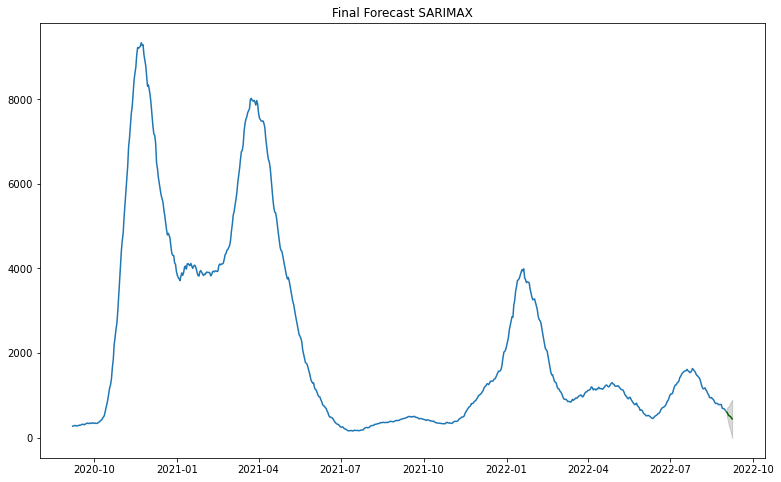

In [16]:
# Forecast
n_periods = 7
fitted_values, confint = sxmodel_all.predict(n_periods=n_periods, 
                                  exogenous=exog_series_prediction.values.reshape(-1,1), 
                                  return_conf_int=True)



index_of_fc = pd.date_range(series.index[-1]+timedelta(days=1), periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted_values, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(13,8))
plt.plot(series)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title("Final Forecast SARIMAX")
plt.show()

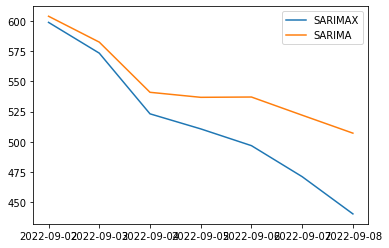

Difference between SARIMAX and SARIMA forecasting:
Mean Squared Error: 1402.098
Root Mean Sqarred Error: 37.4446
Mean Absolute Error: 30.921
Mean Absolute Percentage Error: 6.445


In [17]:
# difference between SARIMAX and SARIMA forecasting

plt.plot(fitted_series,label='SARIMAX')
plt.plot(fc_series,label='SARIMA')
plt.legend()
plt.show()


print('Difference between SARIMAX and SARIMA forecasting:')
calcError(fitted_series,fc_series)

In [18]:
fitted_series.head(n_periods)

2022-09-02    598.976218
2022-09-03    573.475771
2022-09-04    523.176043
2022-09-05    510.693390
2022-09-06    496.799426
2022-09-07    471.080268
2022-09-08    440.220912
Freq: D, dtype: float64

In [19]:
fc_series.head(n_periods)

2022-09-02    604.063913
2022-09-03    582.618995
2022-09-04    541.020470
2022-09-05    536.858633
2022-09-06    537.108135
2022-09-07    522.047372
2022-09-08    507.151631
Freq: D, dtype: float64